### Import

In [1]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary
from transformers import ViTConfig, ViTModel

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder
from architecture import Transformer

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
test_mode = False

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 365
PRED_LEN = 100

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": []
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": StandardScaler},
    "embedding_cols": ["day",  "dow", "month", "holiday"],
    "img_cols": []
}

# Model
batch_size = 32
nhead = 4
dropout = 0.1
is_identical = False

d_model = {"encoder":64, "decoder":32}
d_ff = {"encoder":64, "decoder":32}
num_layers = {"encoder":2, "decoder":2}
remain_rto = {"target": 0.25, "temporal":0.25, "img":0.25}

# Data

### Raw data

In [3]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]

data_info = DataInfo(modality_info, processing_info)

6


In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items() if "scaler" not in key and "img_raw" not in key]
    break

100%|██████████| 29388/29388 [00:01<00:00, 19304.47it/s]


sales torch.Size([32, 365, 1])
sales_remain_idx torch.Size([32, 91])
sales_masked_idx torch.Size([32, 274])
sales_revert_idx torch.Size([32, 365])
sales_remain_padding_mask torch.Size([32, 91])
sales_masked_padding_mask torch.Size([32, 274])
sales_revert_padding_mask torch.Size([32, 365])
day torch.Size([32, 365])
day_remain_idx torch.Size([32, 91])
day_masked_idx torch.Size([32, 274])
day_revert_idx torch.Size([32, 365])
day_remain_padding_mask torch.Size([32, 91])
day_masked_padding_mask torch.Size([32, 274])
day_revert_padding_mask torch.Size([32, 365])
dow torch.Size([32, 365])
dow_remain_idx torch.Size([32, 91])
dow_masked_idx torch.Size([32, 274])
dow_revert_idx torch.Size([32, 365])
dow_remain_padding_mask torch.Size([32, 91])
dow_masked_padding_mask torch.Size([32, 274])
dow_revert_padding_mask torch.Size([32, 365])
month torch.Size([32, 365])
month_remain_idx torch.Size([32, 91])
month_masked_idx torch.Size([32, 274])
month_revert_idx torch.Size([32, 365])
month_remain_padding

# Train

### Model

In [6]:
model = Transformer(data_info, train_dataset.label_encoder_dict,
                        d_model, num_layers, nhead, d_ff, dropout, activation="gelu")
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

-------------------------------------------------------------------------------------------
   Parent Layers           Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer    ModalityEmbedding-1                                 384             384
     Transformer              Encoder-2       [32, 546, 64]          50,432          50,432
     Transformer               Linear-3       [32, 546, 32]           2,080           2,080
     Transformer                Split-4                                   0               0
     Transformer    ModalityEmbedding-5                                 192             192
Total params: 53,088
Trainable params: 53,088
Non-trainable params: 0
-------------------------------------------------------------------------------------------


'-------------------------------------------------------------------------------------------\n   Parent Layers           Layer (type)        Output Shape         Param #     Tr. Param #\n===========================================================================================\n     Transformer    ModalityEmbedding-1                                 384             384\n     Transformer              Encoder-2       [32, 546, 64]          50,432          50,432\n     Transformer               Linear-3       [32, 546, 32]           2,080           2,080\n     Transformer                Split-4                                   0               0\n     Transformer    ModalityEmbedding-5                                 192             192\n===========================================================================================\nTotal params: 53,088\nTrainable params: 53,088\nNon-trainable params: 0\n-----------------------------------------------------------------------------------------

# Train

In [7]:
import datetime

class tc():
    def __init__(self, msg):
        self.msg = msg

    def __enter__(self):
        self.start = datetime.datetime.now()
    
    def __exit__(self, type, value, traceback):
        print(f"{self.msg}:", datetime.datetime.now() - self.start)
        print("_"*100)

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def temporal_loss(col, pred, y, data, device):
    pred = pred.to(device).squeeze()
    y = y.to(device).squeeze()

    masked_idx = data[f"{col}_masked_idx"].squeeze().to(device)
    padding_mask = data[f"{col}_masked_padding_mask"].squeeze().to(device)

    masked_y = torch.gather(y, index=masked_idx, dim=1)

    if col in data_info.processing_info["embedding_cols"]:
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)
        
        masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
        masked_y = masked_y.reshape(-1)
        
        loss = ce_loss(masked_pred, masked_y.to(torch.long)).reshape(padding_mask.shape)
    
    elif col in data_info.processing_info["scaling_cols"]:
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)
        
        loss = mse_loss(masked_pred, masked_y)
    
    loss = loss * padding_mask
    loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))
    
    return loss

def plot_epoch_loss():
    pass

def plot_sample_loss(model, data, remain_rto, device, train_mean_loss_dict, eval_mean_loss_dict):
    model.eval()
    # Get eval prediction
    with torch.no_grad():
        temporal_sample_output, self_attn_dict, cross_attn_dict = model(data, remain_rto, device)
        
        # Temporal train loss
        loss_dict = defaultdict(list)
        for col, val in temporal_sample_output.items():
            y = data[col]

            if col in data_info.processing_info["scaling_cols"]:
                scaler = data[f"{col}_scaler"]
                
                for n, (s, _, _) in enumerate(zip(scaler, y, val)):
                    y[n] = torch.tensor(s.inverse_transform(y[n].clone().detach()))
                    val[n] = torch.tensor(s.inverse_transform(val[n].clone().detach().cpu()))

            loss = temporal_loss(col, val, y, data, device)
            loss_dict[col].append(loss)
        
        latest_loss = {key:val[-1] for key, val in loss_dict.items()}
        loss = torch.nansum(torch.stack(list(latest_loss.values())))

        # Dictionary for plot
        eval_mean_loss_dict["total_loss"].append(loss.item())
        for key, val in loss_dict.items():
            val = np.array([i.item() for i in val])
            eval_mean_loss_dict[key].append(val.mean())

    # Plot
    idx = 0
    plt.figure(figsize=(25,13))
    nrows, ncols = len(data_info.modality_info["target"] + data_info.modality_info["temporal"])+1, 5
    clear_output(wait=True)

    # Plot loss
    plt.subplot(nrows, ncols, 1)
    plt.plot(train_mean_loss_dict["total_loss"])
    plt.title(f'Train total loss: {train_mean_loss_dict["total_loss"][-1]}')

    # Plot loss
    plt.subplot(nrows, ncols, 2)
    plt.plot(eval_mean_loss_dict["total_loss"])
    plt.title(f'Eval total loss: {eval_mean_loss_dict["total_loss"][-1]}')

    plot_idx = 6
    for key, val in temporal_sample_output.items():
        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(train_mean_loss_dict[key])
        plt.title(f"{key} train loss: {train_mean_loss_dict[key][-1]}")
        plot_idx += 1

        # Plot loss
        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(eval_mean_loss_dict[key])
        plt.title(f"{key} eval loss: {eval_mean_loss_dict[key][-1]}")
        plot_idx += 1

        # Plot sample
        masked_idx = data[f"{key}_masked_idx"][idx]
        y = data[key][idx].squeeze()
        sample = val[idx].squeeze().detach().cpu()
        if key in data_info.processing_info["embedding_cols"]:
            sample = torch.argmax(sample, dim=-1).to(torch.float)
        
        sample_full = torch.zeros(y.shape) + torch.nan
        sample = torch.gather(sample, index=masked_idx, dim=-1)
        sample_full[masked_idx] = sample

        plt.subplot(nrows, ncols, plot_idx)
        plt.plot(y)
        plt.plot(sample_full)
        plt.scatter(torch.arange(sample_full.shape[0]), sample_full, color="red", s=15)
        plt.title(f"{key} sample")
        plot_idx += 1

        # Plot self attention
        plt.subplot(nrows, ncols, plot_idx)
        sns.heatmap(self_attn_dict[key][idx].detach().cpu())
        plt.title(f"{key} self attention weight")
        plot_idx += 1

        # Plot cross attention
        plt.subplot(nrows, ncols, plot_idx)
        cross_attn = cross_attn_dict[key][idx].squeeze().detach().cpu() 
        cross_attn = cross_attn.mean(dim=0)
        sns.heatmap(cross_attn)
        plt.title(f"{key} cross attention weight")
        plot_idx += 1

    return eval_mean_loss_dict
        
    
1==1

True

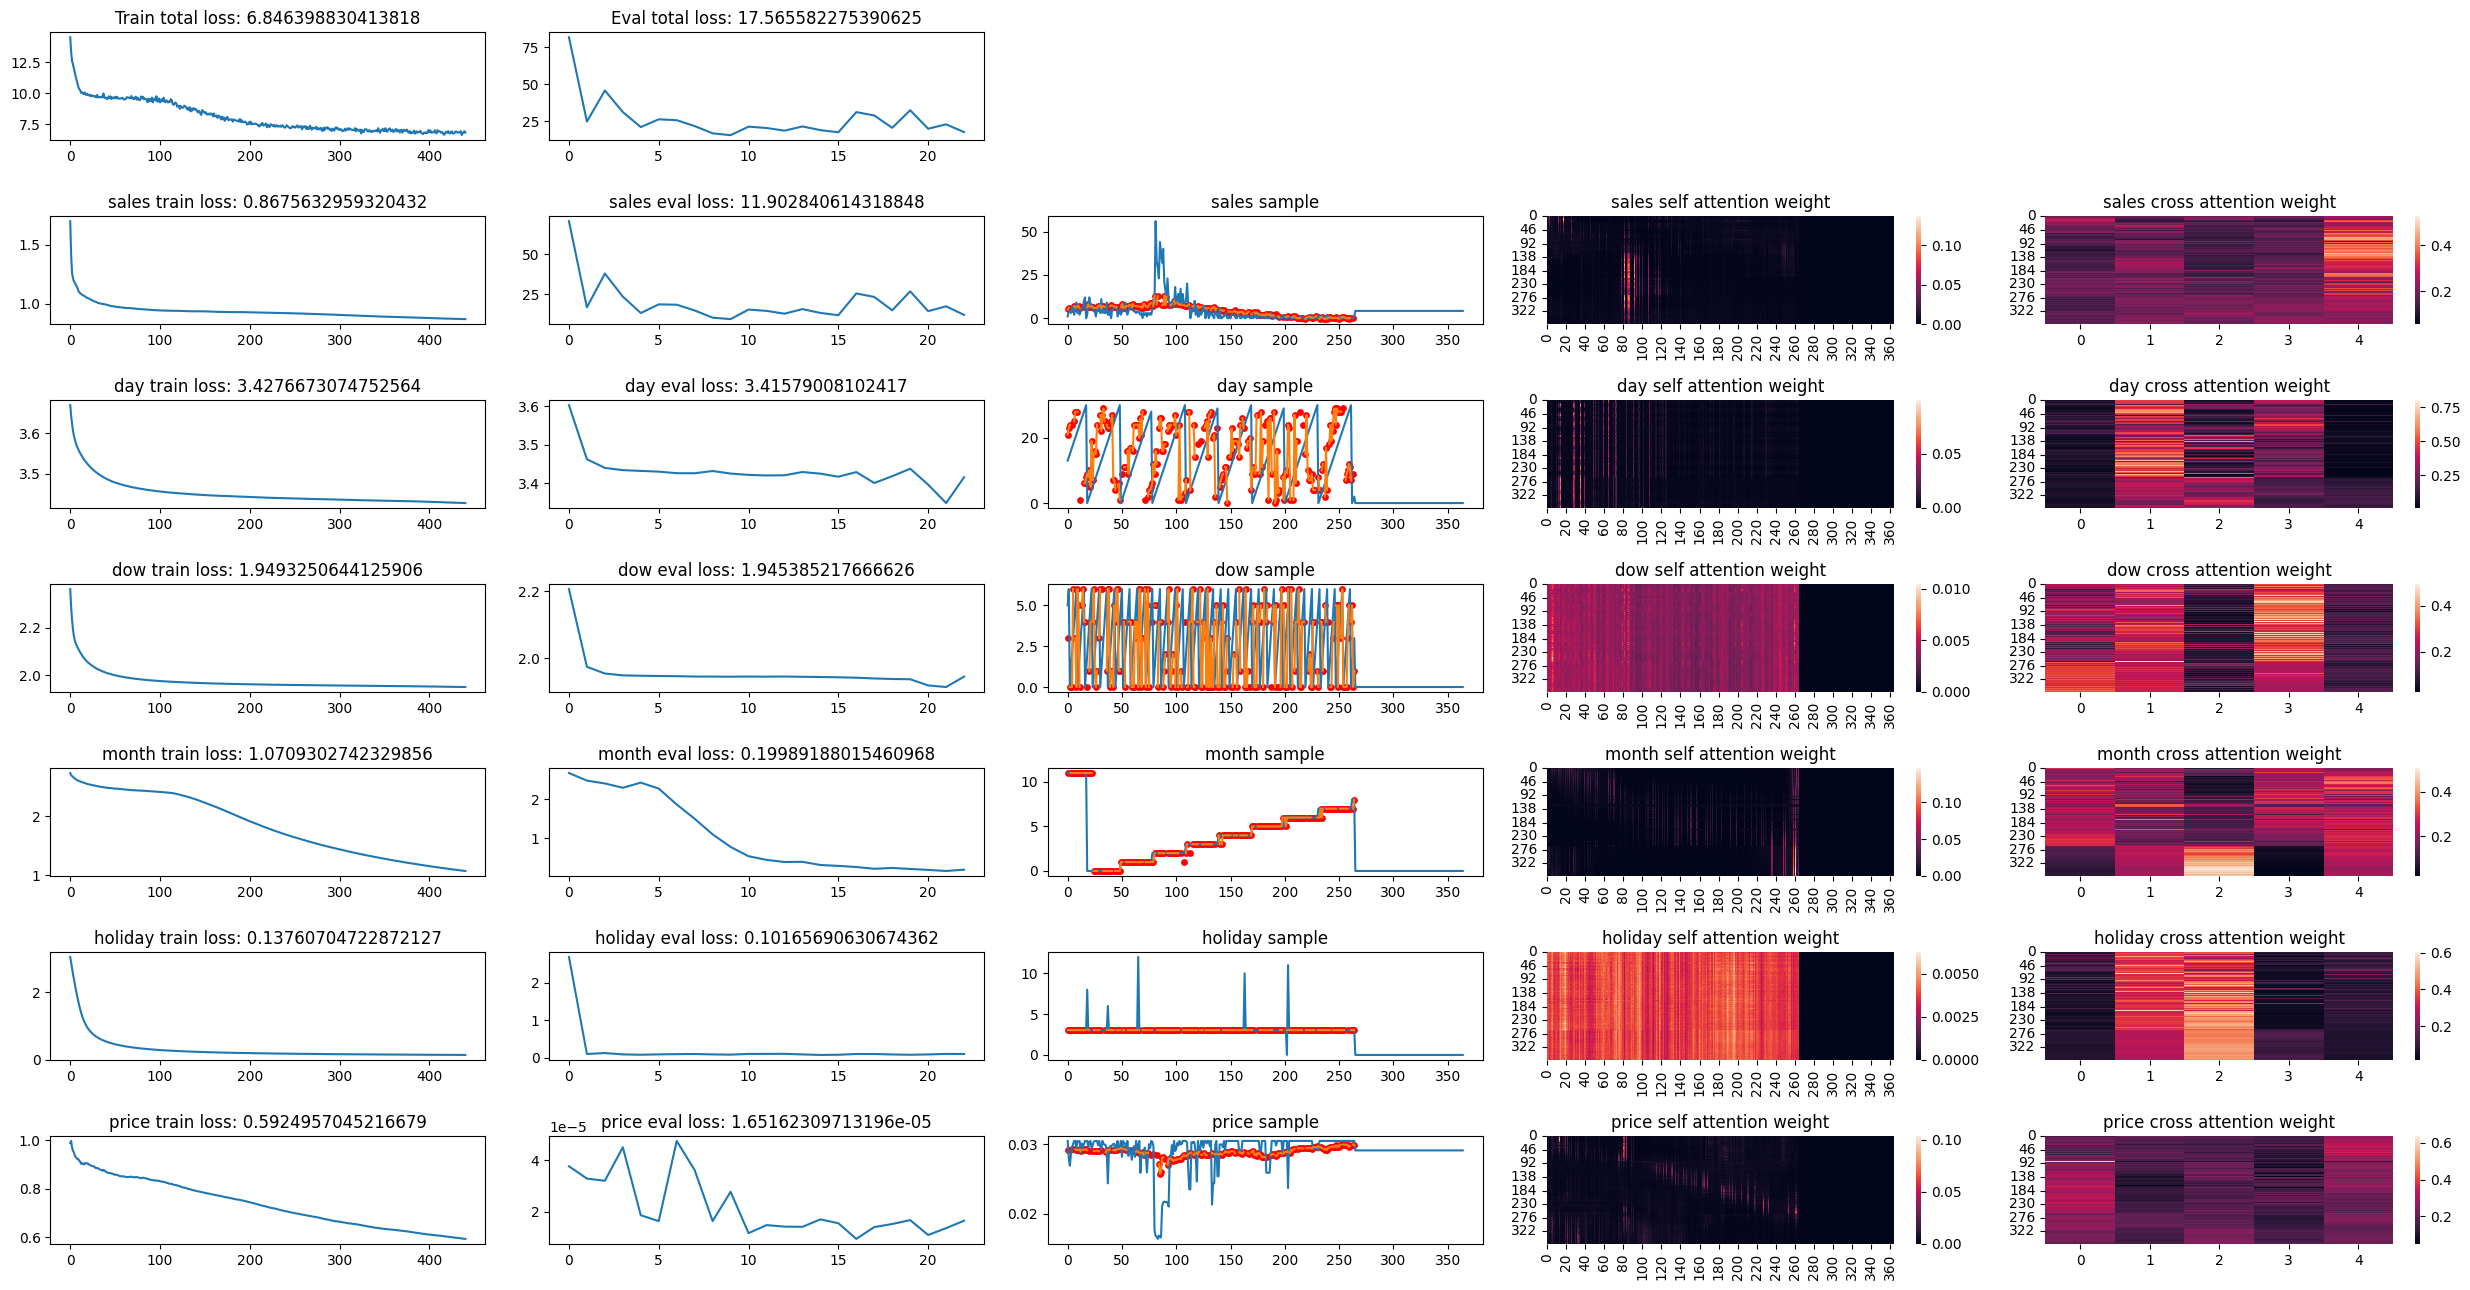

 50%|████▉     | 459/919 [06:08<04:29,  1.71it/s]

In [10]:
def train(e):
    pbar = tqdm(train_dataloader)
    loss_dict, train_mean_loss_dict, eval_mean_loss_dict = defaultdict(list), defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        model.train()
        temporal_output, self_attn_dict, cross_attn_dict = model(data, remain_rto, device)

        # Temporal train loss
        for col, val in temporal_output.items():
            y = data[col]
            loss = temporal_loss(col, val, y, data, device)
            loss_dict[col].append(loss)
        
        latest_loss = {key:val[-1] for key, val in loss_dict.items()}
        loss = torch.nansum(torch.stack(list(latest_loss.values())))
        loss.backward()
        optimizer.step()

        # Dictionary for plot
        train_mean_loss_dict["total_loss"].append(loss.item())
        for key, val in loss_dict.items():
            val = np.array([i.item() for i in val])
            train_mean_loss_dict[key].append(val.mean())

        if n % 20 == 0:
            plot_epoch_loss()
            eval_mean_loss_dict = plot_sample_loss(model, data, remain_rto, device, train_mean_loss_dict, eval_mean_loss_dict)
            plt.tight_layout()
            plt.show()
    
    return 

epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()

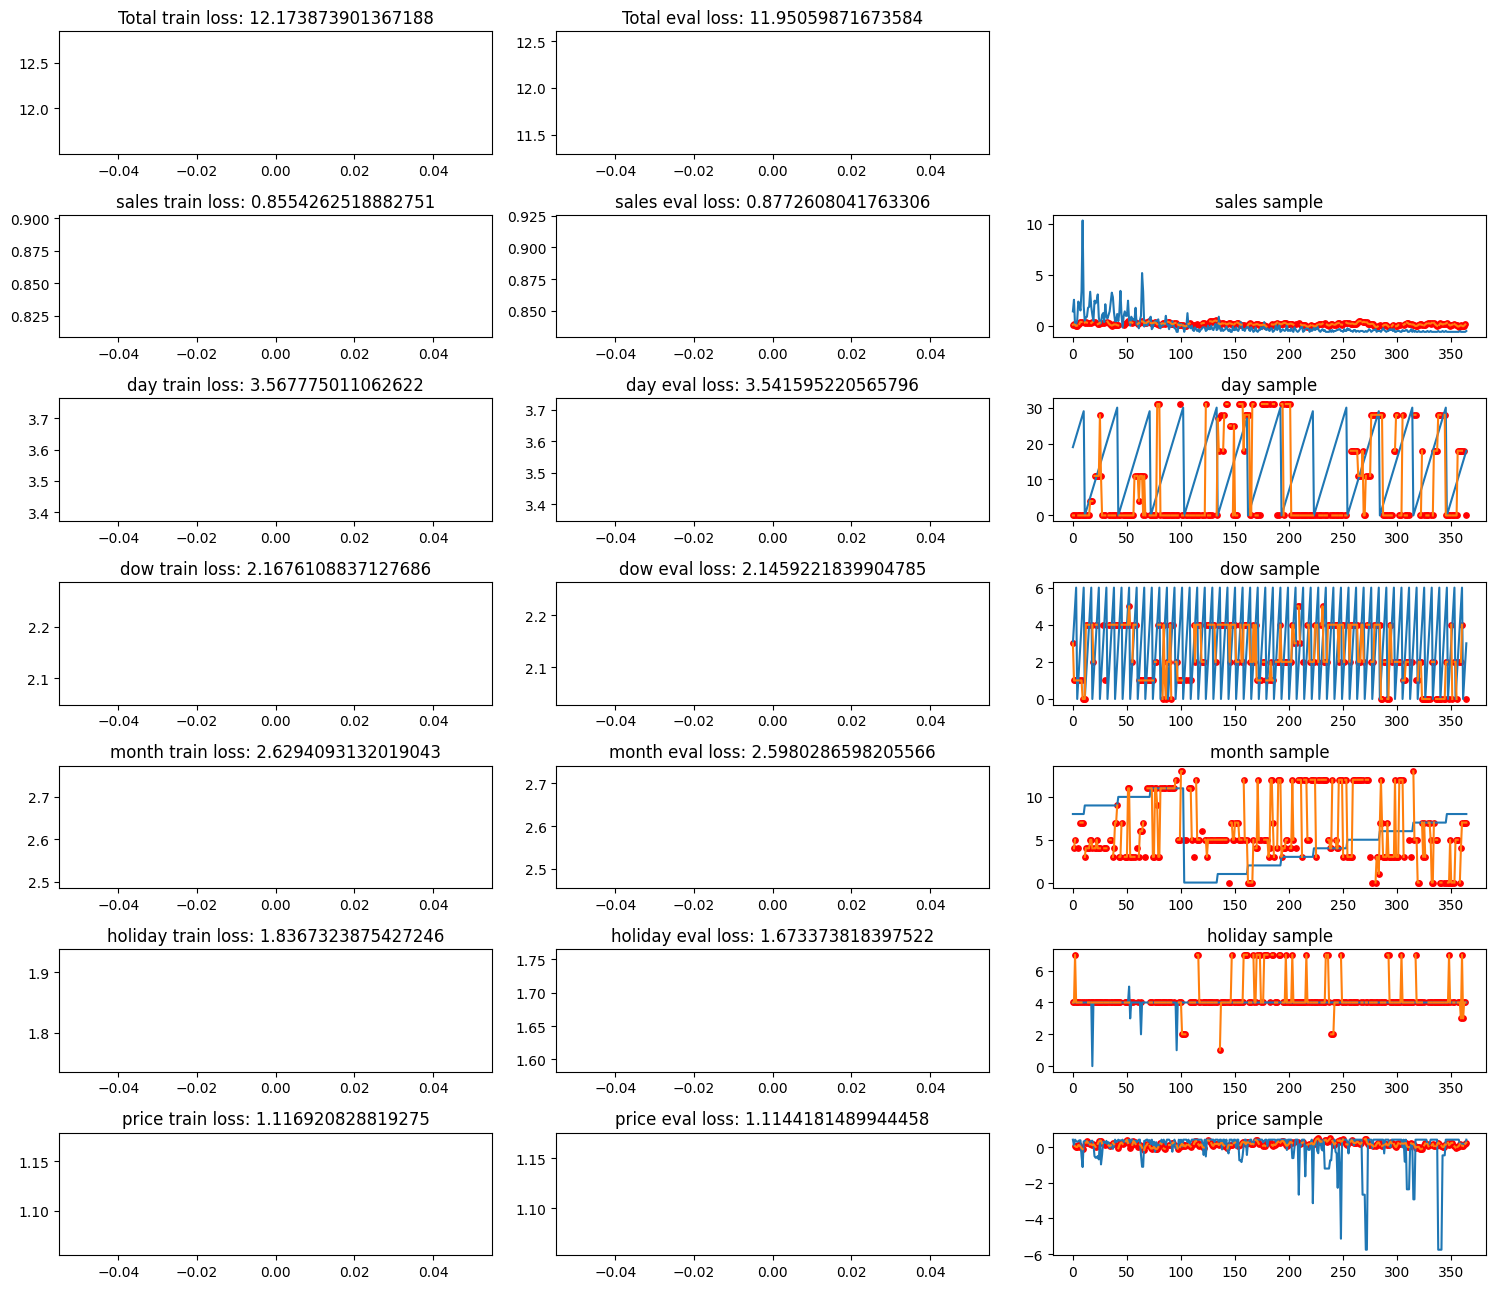

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([2, 365, 64])
torch.Size([2, 365, 64])
____________________________________________________________________________________________________
torch.Size([2, 365, 64])
torch.Size([2, 365, 64])
____________________________________________________________________________________________________
torch.Size([2, 365, 64])
torch.Size([2, 365, 64])
____________________________________________________________________________________________________
torch.Size([2, 365, 64])
torch.Size([2, 365, 64])
____________________________________________________________________________________________________
torch.Size([2, 365, 64])
torch.Size([2, 365, 64])
____________________________________________________________________________________________________
torch.Size([2, 365, 64])
torch.Size([2, 365, 64])
____________________________________________________________________________________________________
torch.Size([2, 365, 64])
torch.Size([2, 365, 64])
____________________________________________

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def loss_fn(key, val, y, idx_dict, padding_mask_dict):
    pred = val.squeeze()
    y = y.to(device).squeeze()

    masked_idx = idx_dict[f"{key}_masked_idx"].squeeze()
    padding_mask = padding_mask_dict[f"{key}_masked_padding_mask"].squeeze()

    if key in list(data_info.processing_info["scaling_cols"].keys()):
        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)
        
        loss = mse_loss(masked_pred, masked_y)
    elif key in data_info.processing_info["embedding_cols"]:
        masked_y = torch.gather(y, index=masked_idx, dim=1)
        masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        masked_pred = torch.gather(pred, index=masked_idx, dim=1)

        masked_pred = masked_pred.reshape(-1, masked_pred.shape[-1])
        masked_y = masked_y.reshape(-1).to(torch.long)

        loss = ce_loss(masked_pred, masked_y).reshape(padding_mask.shape)

    else: raise Exception(key)


    loss = loss * padding_mask
    loss = sum(loss.view(-1)) / sum(padding_mask.view(-1))


    return loss

def get_loss(temporal_output_dict, idx_dict, padding_mask_dict):
    result_dict = {}
    # Temporal loss
    for key, val in temporal_output_dict.items():
        y = data[key]
        result_dict[key] = loss_fn(key, val, y, idx_dict, padding_mask_dict)

    return result_dict

def train(e):
    pbar = tqdm(train_dataloader)
    train_loss_li_dict, eval_loss_li_dict = defaultdict(list), defaultdict(list)
    train_loss_mean_li_dict, eval_loss_mean_li_dict = defaultdict(list), defaultdict(list)

    for n, data in enumerate(pbar):
        # Train loss
        optimizer.zero_grad()
        model.train()
        temporal_output_dict,\
            self_attn_weight_dict, cross_attn_weight_dict,\
            idx_dict, padding_mask_dict = model(data, remain_rto, device)

        train_loss_dict = get_loss(temporal_output_dict, idx_dict, padding_mask_dict)
        [train_loss_li_dict[key].append(val.item()) for key, val in train_loss_dict.items()]

        total_train_loss = torch.nansum(torch.stack(list(train_loss_dict.values())))
        train_loss_li_dict["total"].append(total_train_loss.item())
        total_train_loss.backward()
        optimizer.step()

        # eval loss
        model.eval()
        with torch.no_grad():
            temporal_output_dict,\
                self_attn_weight_dict, cross_attn_weight_dict,\
                idx_dict, padding_mask_dict = model(data, remain_rto, device)
        
        # for key, val in temporal_output_dict.items():
        #     if key in data_info.processing_info["scaling_cols"]:
        #         scaler = data[f"{key}_scaler"]
        #         for i, s in enumerate(scaler):
        #             data[key][i] = torch.tensor(s.inverse_transform(data[key][i].clone().detach()))
        #             temporal_output_dict[key][i] = torch.tensor(s.inverse_transform(temporal_output_dict[key][i].clone().detach().cpu()))

        eval_loss_dict = get_loss(temporal_output_dict, idx_dict, padding_mask_dict)
        [eval_loss_li_dict[key].append(val.item()) for key, val in eval_loss_dict.items()]

        total_eval_loss = torch.nansum(torch.stack(list(eval_loss_dict.values())))
        eval_loss_li_dict["total"].append(total_eval_loss.item())
        
        # Plot
        if n % 20 == 0:
            idx = 0
            plt.figure(figsize=(25,13))
            nrows, ncols = len(data_info.modality_info["target"] + data_info.modality_info["temporal"])+1, 5
            clear_output(wait=True)

            # Plot total train loss
            plt.subplot(nrows, ncols, 1)
            train_loss_mean = torch.tensor(train_loss_li_dict["total"]).mean()
            train_loss_mean_li_dict["total"].append(train_loss_mean)
            plt.plot(train_loss_mean_li_dict["total"])
            plt.title(f"Total train loss: {train_loss_mean}")

            # Plot total eval loss
            plt.subplot(nrows, ncols, 2)
            eval_loss_mean = torch.tensor(eval_loss_li_dict["total"]).mean()
            eval_loss_mean_li_dict["total"].append(eval_loss_mean)
            plt.plot(eval_loss_mean_li_dict["total"])
            plt.title(f"Total eval loss: {eval_loss_mean}")
            plot_idx = 6

            for key, val in temporal_output_dict.items():
                # Plot train sample loss
                train_sample_loss_mean = torch.tensor(train_loss_li_dict[key]).mean()
                train_loss_mean_li_dict[key].append(train_sample_loss_mean)
                
                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(train_loss_mean_li_dict[key])
                plt.title(f"{key} train loss: {train_loss_mean_li_dict[key][-1]}")
                plot_idx += 1

                # Plot eval sample loss
                eval_sample_loss_mean = torch.tensor(eval_loss_li_dict[key]).mean()
                eval_loss_mean_li_dict[key].append(eval_sample_loss_mean)
                
                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(eval_loss_mean_li_dict[key])
                plt.title(f"{key} eval loss: {eval_loss_mean_li_dict[key][-1]}")
                plot_idx += 1

                # Plot sample
                masked_idx = data[f"{key}_masked_idx"][idx]
                y = data[key][idx].squeeze()
                sample = val[idx].squeeze().detach().cpu()
                if key in data_info.processing_info["embedding_cols"]:
                    sample = torch.argmax(sample, dim=-1).to(torch.float)
                
                sample_full = torch.zeros(y.shape) + torch.nan
                sample = torch.gather(sample, index=masked_idx, dim=-1)
                sample_full[masked_idx] = sample

                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(y)
                plt.plot(sample_full)
                plt.scatter(torch.arange(sample_full.shape[0]), sample_full, color="red", s=15)
                plt.title(f"{key} sample")
                plot_idx += 1

                # # Plot self attention
                # plt.subplot(nrows, ncols, plot_idx)
                # # print(self_attn_dict.shape)
                # # raise
                # sns.heatmap(self_attn_dict[key][idx].detach().cpu())
                # plt.title(f"{key} self attention weight")
                # plot_idx += 1

                # # Plot cross attention
                # plt.subplot(nrows, ncols, plot_idx)
                # cross_attn = cross_attn_dict[key][idx].squeeze().detach().cpu() 
                # cross_attn = cross_attn.mean(dim=0)
                # sns.heatmap(cross_attn)
                # plt.title(f"{key} cross attention weight")
                # plot_idx += 1

                plot_idx += 2

            plt.tight_layout()
            plt.show()
        

epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()